In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from sklearn import svm


from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)',
 u'BOW Test unique (N3BGS/9 features/collapsed)',
 u'Link

In [3]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS',
 u'Erik NB N3BGS Collapsed',
 u'Erik MLP N3BGS Collapsed',
 u'Erik MLP Linked NRC (2930 articles)',
 u'Erik RF Linked NRC (2930 articles) ',
 u'Erik NB Linked NRC (2

In [4]:
p = Pipeline.objects.all()[65]
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

DataSource: 20190228 unbalanced train size=3443
NLP Tool: TF-IDF
Classifier: Light GBM
Task status: Status.SUCCESS


In [5]:
len(p.data_source.articles)

3099

In [6]:
test_data_source = DataSource.objects.all()[39]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: 20190228 unbalanced test size=3443


In [7]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7f0755a34950>),
 ('StopWordRemoval',
  <newsgac.nlp_tools.transformers.StopWordRemoval at 0x7f0755a34990>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('TFIDF', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuotes object at 0x7f0755a34890>), ('TF-IDF', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.float64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=1.0, max_featu...        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None))]))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [8]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [9]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [10]:
X_train = X
y_train = labels
y_test = labels_test

In [11]:
y_test.shape

(344,)

In [12]:
kernel_list = ['linear', 'rbf', 'poly', 'sigmoid']
# kernel_list = ['linear']
class_weights = [None, 'balanced']

In [13]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
        'kernel': hp.choice('kernel', kernel_list),
        'class_weight': hp.choice('class_weight', class_weights),
        'C': hp.uniform('C', 0, 20),
        'gamma': hp.uniform('gamma',0.001,10)
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [14]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    c = params['C']
    gamma = params['gamma']
    kernel = params['kernel']
    class_weight = params['class_weight']
    
    model = svm.SVC(kernel=kernel,
            C=c,
            random_state=42,
            decision_function_shape='ovr',
            # class_weight=self.class_weight,
            class_weight=class_weight,
            probability=True,
            gamma=gamma)
    
    model.fit(X_train, y_train)
    labels_prediction = model.predict(X_test)
    labels_probs = model.predict_proba(X_test)
    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, labels_prediction)
    test_loss = log_loss(y_test, labels_probs)
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [15]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 48
start = time.time()
evaluations = 10
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['kernel'] = kernel_list[best_param['kernel']]
best_param['class_weight'] = class_weights[best_param['class_weight']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 0/10 [00:00<?, ?it/s]


  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]
Parameters with this training accuracy 0.891900613101 and loss 1.30600111834 :

  0%|          | 0/10 [02:42<?, ?it/s, best loss: ?]
Parameters with this testing accuracy 0.44476744186 and loss 1.65899169479 :

  0%|          | 0/10 [02:42<?, ?it/s, best loss: ?]
{'kernel': 'poly', 'C': 4.973009636125858, 'gamma': 0.4360592553431118, 'class_weight': 'balanced'}

  0%|          | 0/10 [02:42<?, ?it/s, best loss: ?]

Hyperopt:  10%|█         | 1/10 [02:42<24:23, 162.61s/it]


 10%|█         | 1/10 [02:42<24:23, 162.60s/it, best loss: -0.44476744186]
Parameters with this training accuracy 0.996450467893 and loss 1.17658104266 :

 10%|█         | 1/10 [05:37<24:23, 162.60s/it, best loss: -0.44476744186]
Parameters with this testing accuracy 0.433139534884 and loss 1.6213094774 :

 10%|█         | 1/10 [05:37<24:23, 162.60s/it, best loss: -0.44476744186]
{'kernel': 'poly', 'C': 13.633813144074633, 'gamma': 5.184094496055288, 'class_weight': 'balanced'}

 10%|█         | 1/10 [05:37<24:23, 162.60s/it, best loss: -0.44476744186]

Hyperopt:  20%|██        | 2/10 [05:37<22:10, 166.35s/it]


 20%|██        | 2/10 [05:37<22:10, 166.34s/it, best loss: -0.44476744186]
Parameters with this training accuracy 0.996450467893 and loss 1.17095712472 :

 20%|██        | 2/10 [08:27<22:10, 166.34s/it, best loss: -0.44476744186]
Parameters with this testing accuracy 0.433139534884 and loss 1.62109117743 :

 20%|██        | 2/10 [08:27<22:10, 166.34s/it, best loss: -0.44476744186]
{'kernel': 'poly', 'C': 12.502759049206931, 'gamma': 5.0334881569026235, 'class_weight': None}

 20%|██        | 2/10 [08:27<22:10, 166.34s/it, best loss: -0.44476744186]

Hyperopt:  30%|███       | 3/10 [08:27<19:31, 167.31s/it]


 30%|███       | 3/10 [08:27<19:31, 167.30s/it, best loss: -0.44476744186]
Parameters with this training accuracy 0.207163601162 and loss 1.90881349613 :

 30%|███       | 3/10 [11:00<19:31, 167.30s/it, best loss: -0.44476744186]
Parameters with this testing accuracy 0.162790697674 and loss 1.89115660412 :

 30%|███       | 3/10 [11:00<19:31, 167.30s/it, best loss: -0.44476744186]
{'kernel': 'sigmoid', 'C': 4.026079386816798, 'gamma': 0.9536605487206085, 'class_weight': 'balanced'}

 30%|███       | 3/10 [11:00<19:31, 167.30s/it, best loss: -0.44476744186]

Hyperopt:  40%|████      | 4/10 [11:00<16:18, 163.01s/it]


 40%|████      | 4/10 [11:00<16:18, 163.00s/it, best loss: -0.44476744186]
Parameters with this training accuracy 0.995159728945 and loss 0.210083491074 :

 40%|████      | 4/10 [13:20<16:18, 163.00s/it, best loss: -0.44476744186]
Parameters with this testing accuracy 0.642441860465 and loss 1.0777950372 :

 40%|████      | 4/10 [13:20<16:18, 163.00s/it, best loss: -0.44476744186]
{'kernel': 'linear', 'C': 15.278357185528439, 'gamma': 7.867216386889451, 'class_weight': 'balanced'}

 40%|████      | 4/10 [13:20<16:18, 163.00s/it, best loss: -0.44476744186]

Hyperopt:  50%|█████     | 5/10 [13:20<13:01, 156.29s/it]


 50%|█████     | 5/10 [13:20<13:01, 156.29s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.181348822201 and loss 1.81020026274 :

 50%|█████     | 5/10 [15:31<13:01, 156.29s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.142441860465 and loss 1.81115959942 :

 50%|█████     | 5/10 [15:31<13:01, 156.29s/it, best loss: -0.642441860465]
{'kernel': 'sigmoid', 'C': 13.234833593340658, 'gamma': 9.26373368648936, 'class_weight': 'balanced'}

 50%|█████     | 5/10 [15:31<13:01, 156.29s/it, best loss: -0.642441860465]

Hyperopt:  60%|██████    | 6/10 [15:31<09:54, 148.62s/it]


 60%|██████    | 6/10 [15:31<09:54, 148.62s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.996450467893 and loss 1.17459730045 :

 60%|██████    | 6/10 [18:16<09:54, 148.62s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.433139534884 and loss 1.62209092202 :

 60%|██████    | 6/10 [18:16<09:54, 148.62s/it, best loss: -0.642441860465]
{'kernel': 'poly', 'C': 19.387495262844645, 'gamma': 3.6859397030146135, 'class_weight': 'balanced'}

 60%|██████    | 6/10 [18:16<09:54, 148.62s/it, best loss: -0.642441860465]

Hyperopt:  70%|███████   | 7/10 [18:16<07:40, 153.49s/it]


 70%|███████   | 7/10 [18:16<07:40, 153.49s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.169409486931 and loss 1.8734869389 :

 70%|███████   | 7/10 [20:34<07:40, 153.49s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.110465116279 and loss 1.85043818765 :

 70%|███████   | 7/10 [20:34<07:40, 153.49s/it, best loss: -0.642441860465]
{'kernel': 'sigmoid', 'C': 13.19777110134927, 'gamma': 3.1159292903418603, 'class_weight': 'balanced'}

 70%|███████   | 7/10 [20:34<07:40, 153.49s/it, best loss: -0.642441860465]

Hyperopt:  80%|████████  | 8/10 [20:34<04:57, 148.78s/it]


 80%|████████  | 8/10 [20:34<04:57, 148.78s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.995805098419 and loss 0.196942378424 :

 80%|████████  | 8/10 [22:53<04:57, 148.78s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.651162790698 and loss 1.08150507356 :

 80%|████████  | 8/10 [22:53<04:57, 148.78s/it, best loss: -0.642441860465]
{'kernel': 'linear', 'C': 5.370547091941049, 'gamma': 8.405408815461676, 'class_weight': None}

 80%|████████  | 8/10 [22:53<04:57, 148.78s/it, best loss: -0.642441860465]

Hyperopt:  90%|█████████ | 9/10 [22:53<02:26, 146.04s/it]


 90%|█████████ | 9/10 [22:53<02:26, 146.04s/it, best loss: -0.651162790698]
Parameters with this training accuracy 0.996450467893 and loss 2.60743022168 :

 90%|█████████ | 9/10 [26:43<02:26, 146.04s/it, best loss: -0.651162790698]
Parameters with this testing accuracy 0.46511627907 and loss 1.93744329905 :

 90%|█████████ | 9/10 [26:43<02:26, 146.04s/it, best loss: -0.651162790698]
{'kernel': 'rbf', 'C': 18.48509597604255, 'gamma': 8.835841039859861, 'class_weight': 'balanced'}

 90%|█████████ | 9/10 [26:43<02:26, 146.04s/it, best loss: -0.651162790698]

Hyperopt: 100%|██████████| 10/10 [26:43<00:00, 171.04s/it]


100%|██████████| 10/10 [26:43<00:00, 171.04s/it, best loss: -0.651162790698]------------------------------------
('The best hyperparameters are: ', '\n')
{'kernel': 0, 'C': 5.370547091941049, 'gamma': 8.405408815461676, 'class_weight': 0}
Time elapsed to optimize 10 executions: 1603.24613714

 Best score:


Parameters with this training accuracy 0.995805098419 and loss 0.197679786532 :
Parameters with this testing accuracy 0.651162790698 and loss 1.08168052103 :
{'kernel': 'linear', 'C': 5.370547091941049, 'gamma': 8.405408815461676, 'class_weight': None}


{'loss': -0.6511627906976745, 'status': 'ok'}

In [16]:
# get the best params and train the model
SVC_opt = svm.SVC(kernel=best_param['kernel'],
            C=best_param['C'],
            random_state=42,
            decision_function_shape='ovr',
            # class_weight=self.class_weight,
            class_weight=best_param['class_weight'],
            probability=True,
            gamma=best_param['gamma'])


fitted_model = SVC_opt.fit(X=X_train,y=y_train)

In [17]:
y_score = fitted_model.decision_function(X_test)
y_score

array([[13.10294832,  4.97329091,  6.0124811 , ...,  9.03743599,
         1.91422364,  0.81735311],
       [15.2383287 ,  1.88872993,  3.94637936, ...,  0.8466485 ,
        -0.1922721 , 10.03442645],
       [ 9.03301844, 11.14478948, 10.08136427, ...,  6.00466299,
         4.92385279,  3.9106869 ],
       ...,
       [13.10258485,  4.99179658,  3.98069725, ...,  3.99068329,
         9.02847324,  1.89607295],
       [15.21807966,  0.82993604,  3.87408754, ...,  2.89571694,
        10.05052388, -0.25438888],
       [14.19644259,  9.02163649,  9.01059615, ...,  2.93304507,
        -0.17412783,  4.94400294]])

In [18]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.6511627906976745

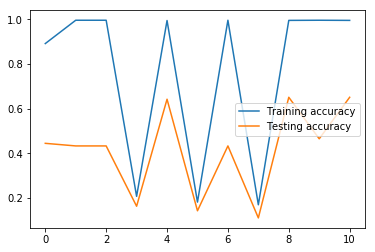

In [19]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

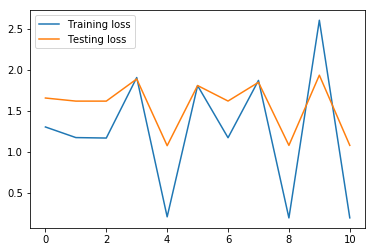

In [20]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()